This notebook preprocesses the following raw data for the period Dec 2019 to Feb 2020 and Dec 2021 to Feb 2022:
- NYC Yellow Taxi Data 
- NYC For Hire Vehicles High Volume (FHVHV) Data
- NYC COVID-19 Data (Dec 2021-Feb 2022 only)

In [29]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

<h2><u>Preprocess TLC Data</u></h2>

In [30]:
# load yellow taxi data
yellow_2019_12_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2019-12.parquet', header=True)
yellow_2020_01_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2020-01.parquet', header=True)
yellow_2020_02_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2020-02.parquet', header=True)

yellow_2021_12_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2021-12.parquet', header=True)
yellow_2022_01_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2022-01.parquet', header=True)
yellow_2022_02_sdf = spark.read.parquet('../data/raw/NYC TLC Data/yellow_tripdata_2022-02.parquet', header=True)

# load FHV data
fhvhv_2019_12_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2019-12.parquet', header=True)
fhvhv_2020_01_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2020-01.parquet', header=True)
fhvhv_2020_02_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2020-02.parquet', header=True)

fhvhv_2021_12_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2021-12.parquet', header=True)
fhvhv_2022_01_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2022-01.parquet', header=True)
fhvhv_2022_02_sdf = spark.read.parquet('../data/raw/NYC TLC Data/fhvhv_tripdata_2022-02.parquet', header=True)

# merge datasets categorised by type and period
yellow_19_20_sdf = yellow_2019_12_sdf.unionAll(yellow_2020_01_sdf).unionAll(yellow_2020_02_sdf)
yellow_21_22_sdf = yellow_2021_12_sdf.unionAll(yellow_2022_01_sdf).unionAll(yellow_2022_02_sdf)

fhvhv_19_20_sdf = fhvhv_2019_12_sdf.unionAll(fhvhv_2020_01_sdf).unionAll(fhvhv_2020_02_sdf)
fhvhv_21_22_sdf = fhvhv_2021_12_sdf.unionAll(fhvhv_2022_01_sdf).unionAll(fhvhv_2022_02_sdf)

<h3>Feature engineering</h3>

**Yellow Taxis**

In [31]:
def yellow_taxi_feature_eng(data_sdf):
    # trip duration in minutes
    data_sdf_eng = data_sdf.withColumn(
        'trip_time',
        (F.col('tpep_dropoff_datetime').cast('long') - F.col('tpep_pickup_datetime').cast('long'))/60
    )

    # pickup day is weekend or not
    data_sdf_eng = data_sdf_eng.withColumn(
        'is_weekend',
        F.dayofweek(F.col('tpep_pickup_datetime')).isin([1, 7])
    )

    # rename pickup/dropoff date time to match fhvhv
    data_sdf_eng = data_sdf_eng.withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
    data_sdf_eng = data_sdf_eng.withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')

    return data_sdf_eng

yellow_19_20_sdf_eng = yellow_taxi_feature_eng(yellow_19_20_sdf)
yellow_21_22_sdf_eng = yellow_taxi_feature_eng(yellow_21_22_sdf)


**FHV**

In [32]:
def fhvhv_feature_eng(data_sdf):
    # trip duration in mniutes
    data_sdf_eng = data_sdf.withColumn(
        'trip_time',
        F.col('trip_time')/60
    )

    # fill null values in airport_fee with 0
    data_sdf_eng = data_sdf_eng.na.fill(value=0, subset=['airport_fee'])

    # total amount paid by passenger
    data_sdf_eng = data_sdf_eng.withColumn(
        'total_amount',
        F.col('base_passenger_fare') + F.col('tolls') + F.col('sales_tax') + F.col('tips') + F.col('airport_fee')
    )

    # pickup day is weekend or not
    data_sdf_eng = data_sdf_eng.withColumn(
        'is_weekend',
        F.dayofweek(F.col('pickup_datetime')).isin([1, 7])
    )

    # rename trip_miles featue to trip_distance
    data_sdf_eng = data_sdf_eng.withColumnRenamed('trip_miles', 'trip_distance')

    # rename tips featue to tip_amount
    data_sdf_eng = data_sdf_eng.withColumnRenamed('tips', 'tip_amount')

    return data_sdf_eng

fhvhv_19_20_sdf_eng = fhvhv_feature_eng(fhvhv_19_20_sdf)
fhvhv_21_22_sdf_eng = fhvhv_feature_eng(fhvhv_21_22_sdf)

<h3>Outlier Detection</h3>

Distribution analysis only performed on Yellow Taxis 2019-2020 dataset, and any outliers detected removed for all datasets

**Total Fare Amount**

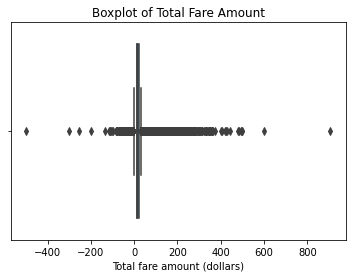

In [38]:
total_amount_yellow_19_20_df = yellow_19_20_sdf_eng.select('total_amount').sample(fraction=0.05, seed=42).toPandas()

sns.boxplot(x = total_amount_yellow_19_20_df['total_amount'])
plt.title('Boxplot of Total Fare Amount')
plt.xlabel('Total fare amount (dollars)')
plt.ylabel('')
plt.savefig('../plots/yellow_19_20_total_amount_raw_boxplot.png')
plt.show()

**Trip Time**

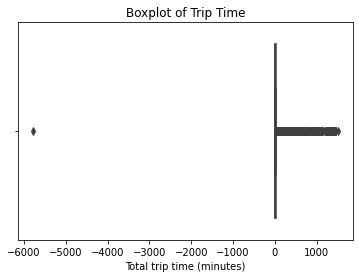

In [39]:
trip_time_yellow_19_20_df = yellow_19_20_sdf_eng.select('trip_time').sample(fraction=0.05, seed=42).toPandas()

sns.boxplot(x = trip_time_yellow_19_20_df['trip_time'])
plt.title('Boxplot of Trip Time')
plt.xlabel('Total trip time (minutes)')
plt.ylabel('')
plt.savefig('../plots/yellow_19_20_trip_time_raw_boxplot.png')
plt.show()

**Passenger Count**

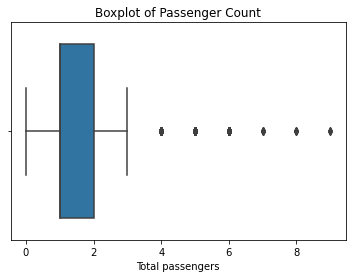

In [40]:
trip_time_yellow_19_20_df = yellow_19_20_sdf_eng.select('passenger_count').sample(fraction=0.05, seed=42).toPandas()

sns.boxplot(x = trip_time_yellow_19_20_df['passenger_count'])
plt.title('Boxplot of Passenger Count')
plt.xlabel('Total passengers')
plt.ylabel('')
plt.savefig('../plots/yellow_19_20_passenger_count_raw_boxplot.png')
plt.show()

**Trip Distance**

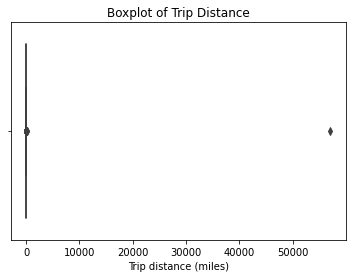

In [41]:
trip_time_yellow_19_20_df = yellow_19_20_sdf_eng.select('trip_distance').sample(fraction=0.05, seed=42).toPandas()

sns.boxplot(x = trip_time_yellow_19_20_df['trip_distance'])
plt.title('Boxplot of Trip Distance')
plt.xlabel('Trip distance (miles)')
plt.ylabel('')
plt.savefig('../plots/yellow_19_20_trip_distance_raw_boxplot.png')
plt.show()

<h3>Outlier Cleaning</h3> 

In [33]:
# select trips with total fare amount more than $0 and less than $400
total_amount_clean_mask = (F.col('total_amount') > 0) & (F.col('total_amount') < 400)

# select trips with trip time more than 0 and less than 300 minutes (0-5 hours)
trip_time_clean_mask = (F.col('trip_time') > 0) & (F.col('trip_time') < 300)

# select trips with passenger counts more than 0 and less than 7 (legal limit in taxis)
passenger_count_clean_mask = (F.col('passenger_count') > 0) & (F.col('passenger_count') < 7)

# select trips with distance more than 0 and less than 300 miles
trip_distance_clean_mask = (F.col('trip_distance') > 0) & (F.col('trip_distance') < 300)

# select trips with tips more than or equal to 0 and less than the total amount
tip_amount_clean_mask = (F.col('tip_amount') >= 0) & (F.col('tip_amount') < F.col('total_amount'))

# select trips only with payment type
payment_time_clean_mask = (F.col('payment_type') == 1) | (F.col('payment_type') == 2)

# select trips with valid location IDs (1 to 263)
location_id_clean_mask = (((F.col('PULocationID') >= 1) & (F.col('PULocationID') <= 263))
                            | ((F.col('DOLocationID') >= 1) & (F.col('DOLocationID') <= 263)))

In [34]:
def clean_data(data_sdf, masks):
    clean_data_sdf = data_sdf.where(masks[0])
    for mask in masks[1:]:
        clean_data_sdf = clean_data_sdf.where(mask)

    return clean_data_sdf

def clean_date_time(data_sdf, start, end):
    return data_sdf.where(F.col('pickup_datetime').between(start, end))

**Yellow Taxis**

In [35]:
masks_yellow = [total_amount_clean_mask, trip_time_clean_mask, passenger_count_clean_mask, trip_distance_clean_mask, 
                tip_amount_clean_mask, payment_time_clean_mask, location_id_clean_mask]

# clean data with masks
yellow_19_20_sdf_cleaned = clean_data(yellow_19_20_sdf_eng, masks_yellow)
yellow_21_22_sdf_cleaned = clean_data(yellow_21_22_sdf_eng, masks_yellow)  

# clean date time
yellow_19_20_sdf_cleaned = clean_date_time(yellow_19_20_sdf_cleaned, '2019-12-01 00:00:00', '2020-02-29 23:59:59')
yellow_21_22_sdf_cleaned = clean_date_time(yellow_21_22_sdf_cleaned, '2021-12-01 00:00:00', '2022-02-28 23:59:59')

print("Original data size for Yellow Taxi 2019-2020:", yellow_19_20_sdf_eng.count()) 
print("Cleaned data size for Yellow Taxi 2019-2020:", yellow_19_20_sdf_cleaned.count())   
print("")
print("Original data size for Yellow Taxi 2021-2022:", yellow_21_22_sdf_eng.count())   
print("Cleaned data size for Yellow Taxi 2021-2022:", yellow_21_22_sdf_cleaned.count())  

Original data size for Yellow Taxi 2019-2020: 19600692


Cleaned data size for Yellow Taxi 2019-2020: 18483810

Original data size for Yellow Taxi 2021-2022: 8657731


Cleaned data size for Yellow Taxi 2021-2022: 7932626


**FHV**

In [36]:
masks_fhvhv = [total_amount_clean_mask, trip_time_clean_mask, trip_distance_clean_mask, 
                tip_amount_clean_mask, location_id_clean_mask]
  
# clean data with masks
fhvhv_19_20_sdf_cleaned = clean_data(fhvhv_19_20_sdf_eng, masks_fhvhv)
fhvhv_21_22_sdf_cleaned = clean_data(fhvhv_21_22_sdf_eng, masks_fhvhv)

# clean date time
fhvhv_19_20_sdf_cleaned = clean_date_time(fhvhv_19_20_sdf_cleaned, '2019-12-01 00:00:00', '2020-02-29 23:59:59')
fhvhv_21_22_sdf_cleaned = clean_date_time(fhvhv_21_22_sdf_cleaned, '2021-12-01 00:00:00', '2022-02-28 23:59:59')

print("Original data size for FHVHV Trips 2019-2020:", fhvhv_19_20_sdf_eng.count())  
print("Cleaned data size for FHVHV Trips 2019-2020:", fhvhv_19_20_sdf_cleaned.count())   

print("Original data size for FHVHV Trips 2021-2022:", fhvhv_21_22_sdf_eng.count())   
print("Cleaned data size for FHVHV Trips 2021-2022:", fhvhv_21_22_sdf_cleaned.count())   


Original data size for FHVHV Trips 2019-2020: 64538369


Cleaned data size for FHVHV Trips 2019-2020: 63272490
Original data size for FHVHV Trips 2021-2022: 46825369


Cleaned data size for FHVHV Trips 2021-2022: 46447305


<h3>Tip Percentage Feature</h3> 

Add tip percentage feature after cleaning all data to ensure unclean data isn't used to calculate

In [37]:
yellow_19_20_sdf_cleaned = yellow_19_20_sdf_cleaned.withColumn(
    'tip_percent',
    (F.col('tip_amount') / F.col('total_amount')) * 100
)

yellow_21_22_sdf_cleaned = yellow_21_22_sdf_cleaned.withColumn(
    'tip_percent',
    (F.col('tip_amount') / F.col('total_amount')) * 100
)

fhvhv_19_20_sdf_cleaned = fhvhv_19_20_sdf_cleaned.withColumn(
    'tip_percent',
    (F.col('tip_amount') / F.col('total_amount')) * 100
)

fhvhv_21_22_sdf_cleaned = fhvhv_21_22_sdf_cleaned.withColumn(
    'tip_percent',
    (F.col('tip_amount') / F.col('total_amount')) * 100
)



<h3>Feature selection</h3>

In [38]:
drop_features_taxi = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 
                'store_and_fwd_flag', 'fare_amount', 'extra',
                'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
                'congestion_surcharge', 'airport_fee', 'trip_time']

yellow_19_20_sdf_final = yellow_19_20_sdf_cleaned.drop(*drop_features_taxi)
yellow_21_22_sdf_final = yellow_21_22_sdf_cleaned.drop(*drop_features_taxi)

In [39]:
yellow_19_20_sdf_final.write.mode('overwrite').parquet('../data/curated/yellow_19-20_curated')

In [40]:
yellow_21_22_sdf_final.write.mode('overwrite').parquet('../data/curated/yellow_21-22_curated')

In [41]:
drop_features_fhvhv = ['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
                        'request_datetime', 'on_scene_datetime', 'trip_distance', 'trip_time',
                        'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge',
                        'airport_fee', 'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag',
                        'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']

fhvhv_19_20_sdf_final = fhvhv_19_20_sdf_cleaned.drop(*drop_features_fhvhv)
fhvhv_21_22_sdf_final = fhvhv_21_22_sdf_cleaned.drop(*drop_features_fhvhv)

In [42]:
fhvhv_19_20_sdf_final.write.mode('overwrite').parquet('../data/curated/fhvhv_19-20_curated')

In [43]:
fhvhv_21_22_sdf_final.write.mode('overwrite').parquet('../data/curated/fhvhv_21-22_curated')

<h2><u>Preprocess COVID Data</u></h2>

In [11]:
# load COVID-19 Daily Counts data
covid_df = pd.read_csv('../data/raw/External Data/COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv')

# select necessary features
covid_df_selected = covid_df[['date_of_interest', 'CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT']]

# select required data between dates 2021-12-01 and 2022-02-28
covid_df_selected['date_of_interest'] = pd.to_datetime(covid_df_selected['date_of_interest'], format='%m/%d/%Y')
mask = (covid_df_selected['date_of_interest'] >= '2021-12-01') & (covid_df_selected['date_of_interest'] <= '2022-2-28')
covid_df_selected = covid_df_selected.loc[mask]

covid_df_selected.to_parquet('../data/curated/nyc_covid_2021-2022_clean.parquet')